In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import warnings
import unidecode
from fuzzywuzzy import process


c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Obtener datos

### Gastos

In [2]:
tipos_de_gastos_files_xls = [
    "data/input/gastos/alcaldia-tipos_de_gastos__alcaldia___2024-03-09T02_06_53.838153Z.xlsx",
    "data/input/gastos/gobernacion-tipos_de_gastos__2024-03-09T02_00_59.376388Z.xlsx",
]


gastos_df = pd.DataFrame()

for f in tipos_de_gastos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    gastos_df = pd.concat([gastos_df, df_temp], ignore_index=True)

## Renombrar las columnas
gastos_df = gastos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Gastos → Total": "Total",
    }
)



### Ingresos

In [3]:
tipos_de_ingresos_files_xls = [
    "data/input/ingresos/alcaldia_tipo_de_ingresos.xlsx",
    "data/input/ingresos/gobernacion_tipo_de_ingresos.xlsx",
]


ingresos_df = pd.DataFrame()

## Concatenar los dos archivos
for f in tipos_de_ingresos_files_xls:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        df_temp = pd.read_excel(f, engine="openpyxl")

    ingresos_df = pd.concat([ingresos_df, df_temp], ignore_index=True)
    

## Renombrar las columnas
ingresos_df = ingresos_df.rename(
    columns={
        "Corporaciones - ID Corporacion → Nombre": "Cargo",
        "Formato Ingresos Gastos - ID Formato Ingresos Gasto → Codigo": "Gasto Id",
        "Candidatos → Sexo": "Sexo",
        "Candidatos → Etnia": "Etnia",
        "Departamentos - ID Departamento → Nombre": "Departamento",
        "Ciudades → Nombre": "Ciudades",
        "Agrupaciones Politicas → Nombre": "Agrupacion Politica",
        "Coalicion Politica → Nombre": "Coalicion Politica",
        "Grupos Significativos → Nombre": "Grupo Politico",
        "Suma de Ingresos → Total": "Total",
        "Codigo pro":"Codigo Pro"
    }
)
    
ingresos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8712 entries, 0 to 8711
Data columns (total 18 columns):
 #   Column                                                        Non-Null Count  Dtype  
---  ------                                                        --------------  -----  
 0   Nombre                                                        8712 non-null   object 
 1   Apellido                                                      8712 non-null   object 
 2   Cargo                                                         8712 non-null   object 
 3   Gasto Id                                                      8712 non-null   int64  
 4   Sexo                                                          8710 non-null   object 
 5   Etnia                                                         4281 non-null   float64
 6   Departamento                                                  8712 non-null   object 
 7   Ciudades                                                      8235 no

# Pre-Procesamiento

## Convertir tres columnas con valores únicos a dos columnas con tipo y valor

In [4]:
columnas_originales = [
    "Agrupacion Politica",
    "Coalicion Politica",
    "Grupo Politico",
]


def categorizar(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]
    if isinstance(aggPolitica, str):
        return "Agrupacion Politica"
    if isinstance(coalicionPolitica, str):
        return "Coalicion Politica"
    if isinstance(grupoPolitico, str):
        return "Grupo Politico"


def categorizarConNombre(fila):
    aggPolitica = fila["Agrupacion Politica"]
    coalicionPolitica = fila["Coalicion Politica"]
    grupoPolitico = fila["Grupo Politico"]

    if isinstance(aggPolitica, str):
        return aggPolitica
    if isinstance(coalicionPolitica, str):
        return coalicionPolitica
    if isinstance(grupoPolitico, str):
        return grupoPolitico


### Gastos

In [5]:


gastos_df["Tipo de Agrupación"] = gastos_df.apply(categorizar, axis=1)
gastos_df["Nombre de Agrupación"] = gastos_df.apply(categorizarConNombre, axis=1)

gastos_df = gastos_df.drop(columns=columnas_originales)
gastos_df.head()

,Nombre,Apellido,Cargo,Gasto Id,Sexo,Etnia,Departamento,Ciudades,Total,Contar,Etnias,Género,Codigo Pro,Tipo de Agrupación,Nombre de Agrupación
0,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,205,M,NaN,Antioquia,San Rafael,10400000.0,3,NaN,Masculino,205 - Servicio de transporte y correo,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
1,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,207,M,NaN,Antioquia,San Rafael,200000.0,1,NaN,Masculino,207 - Gastos judiciales y de rendición de cuentas,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
2,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,208,M,NaN,Antioquia,San Rafael,6030000.0,1,NaN,Masculino,208 - Gastos de propaganda electoral,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
3,ABAD DE JESUS,MARIN ARCILA,Alcaldia_fun,211,M,NaN,Antioquia,San Rafael,1570000.0,1,NaN,Masculino,211 - Otros gastos,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE
4,ABEL ALBERTO,POLANCO LEMOS,Alcaldia_fun,203,M,NaN,Bolívar,Tiquisio,3000000.0,1,NaN,Masculino,203 - Inversión en materiales y publicaciones,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO


### Ingresos

In [6]:
ingresos_df["Tipo de Agrupación"] = ingresos_df.apply(categorizar, axis=1)
ingresos_df["Nombre de Agrupación"] = ingresos_df.apply(categorizarConNombre, axis=1)

ingresos_df = ingresos_df.drop(columns=columnas_originales)



### Funciones generales

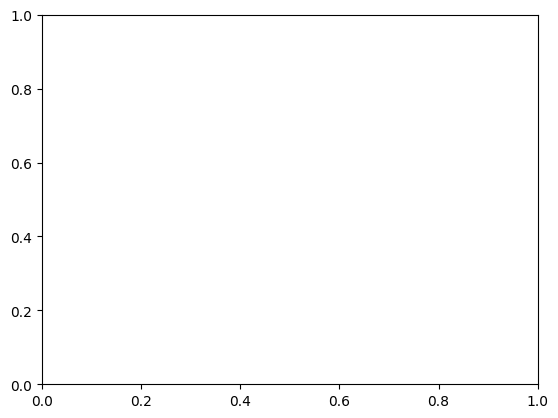

In [7]:

def millions_billions_formatter(x, pos):
    if x >= 1e9:
        return f"{x / 1e9:.0f}B"
    elif x >= 1e6:
        return f"{x / 1e6:.0f}M"
    else:
        return f"{x:.0f}"


func_form_millon_billon = FuncFormatter(millions_billions_formatter)
def truncate_label(label, length=20):
    if len(label) > length:
        return label[: length - 3] + "..."
    else:
        return label


format_long_text = [
    truncate_label(l.get_text()) for l in plt.gca().xaxis.get_ticklabels()
]


def autoLabel():
    for bar in plt.gca().patches:
        height = bar.get_height()

        formatted_height = millions_billions_formatter(height, None)
        plt.gca().annotate(
            formatted_height,
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # Desplazamiento vertical del texto
            textcoords="offset points",
            ha="center",
            va="bottom",
        )
def autoLabelY():
    for bar in plt.gca().patches:
        width = bar.get_width()
        formatted_width = millions_billions_formatter(width, None)
        plt.gca().annotate(
            formatted_width,
            xy=(width, bar.get_y() + bar.get_height() / 2),
            xytext=(3, 0),  # Desplazamiento horizontal del texto
            textcoords="offset points",
            ha="left",
            va="center",
        )


## Concatenar nombre y apellidos

### Gastos

In [8]:
gastos_df['Nombre'] = gastos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_') + '_' + gastos_df['Apellido'].str.strip().str.lower().str.replace(' ', '_')
gastos_df.drop(columns=["Apellido","Género","Etnia","Etnias"], axis=2,inplace=True)
gastos_df.shape


(24308, 11)

In [9]:
gastos_df["Nombre"].unique().size

5955

In [10]:
gastos_df.columns

Index(['Nombre', 'Cargo', 'Gasto Id', 'Sexo', 'Departamento', 'Ciudades',
       'Total', 'Contar', 'Codigo Pro', 'Tipo de Agrupación',
       'Nombre de Agrupación'],
      dtype='object')

In [11]:
gastos_df.dtypes

Nombre                   object
Cargo                    object
Gasto Id                  int64
Sexo                     object
Departamento             object
Ciudades                 object
Total                   float64
Contar                    int64
Codigo Pro               object
Tipo de Agrupación       object
Nombre de Agrupación     object
dtype: object

### Ingreso

In [12]:

ingresos_df['Nombre'] = ingresos_df['Nombre'].str.strip().str.lower().str.replace(' ', '_') + '_' + ingresos_df['Apellido'].str.strip().str.lower().str.replace(' ', '_')
ingresos_df.drop(columns=["Apellido","Género","Etnia","Etnias"], axis=2,inplace=True)
ingresos_df.shape

(8712, 13)

In [13]:
ingresos_df["Nombre"].unique().size

5961

In [14]:
ingresos_df.columns

Index(['Nombre', 'Cargo', 'Gasto Id', 'Sexo', 'Departamento', 'Ciudades',
       'Total', 'Contar', 'Codigo Pro',
       'Formato Ingresos Gastos - ID Formato Ingresos Gasto → Nombre',
       'Tipos Circunscripcion - ID Circunscripcion → Nombre',
       'Tipo de Agrupación', 'Nombre de Agrupación'],
      dtype='object')

## Normalizar columna Codigo por

### Gastos

In [15]:
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica',
       '211 -\xa0Otros\xa0gastos'], dtype=object)

In [16]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("211"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


gastos_df["Codigo Pro"] = gastos_df.apply(normalizeCodigoPro, axis=1)
gastos_df["Codigo Pro"].unique()

array(['205 - Servicio de transporte y correo',
       '207 - Gastos judiciales y de rendición de cuentas',
       '208 - Gastos de propaganda electoral', '211 - Otros gastos',
       '203 - Inversión en materiales y publicaciones',
       '204 - Actos públicos', '201 - Gastos de Administración',
       '202 - Gastos de oficina y adquisiciones',
       '209 - Costos financieros',
       '206 - Gastos de capacitación e investigación politica'],
      dtype=object)

### Ingreso

In [17]:
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos\xa0financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

In [18]:
def normalizeCodigoPro(fila):
    codigo = fila["Codigo Pro"]
    if isinstance(codigo, str):
        if codigo.startswith("107"):
            return codigo.replace("\xa0", " ")
        else:
            return codigo
    else:
        return codigo


ingresos_df["Codigo Pro"] = ingresos_df.apply(normalizeCodigoPro, axis=1)
ingresos_df["Codigo Pro"].unique()

array(['101 - Recursos propios y familiares',
       '102 - Donaciones de particulares',
       '106 - Recursos de origen privado destinado por los partidos',
       '107 - Rendimientos financieros',
       '104 - Ingresos de actos públicos del partido',
       '103 - Créditos de entidades financieras',
       '105 - Financiación estatal - Anticipos'], dtype=object)

## Cada tipo de gasto como columna

## Gastos

In [19]:
gastos_df["Ciudades"].fillna("Desconocido", inplace=True)

gastos_df_i2 = gastos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

gastos_df_i2 = gastos_df_i2.reset_index()

gastos_df_i2.columns.name = None


gastos_df_i2 = gastos_df_i2.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "201 - Gastos de Administración": "sum",
        "202 - Gastos de oficina y adquisiciones": "sum",
        "203 - Inversión en materiales y publicaciones": "sum",
        "204 - Actos públicos": "sum",
        "205 - Servicio de transporte y correo": "sum",
        "206 - Gastos de capacitación e investigación politica": "sum",
        "207 - Gastos judiciales y de rendición de cuentas": "sum",
        "208 - Gastos de propaganda electoral": "sum",
        "209 - Costos financieros": "sum",
        "211 - Otros gastos": "sum",
    }
)
gastos_df_i2.shape

(5916, 18)

In [20]:
duplicated_names = gastos_df_i2[gastos_df_i2.duplicated('Nombre', keep=False)]
duplicated_names

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,211 - Otros gastos
649,carlos_andres_osorio_franco,Alcaldia_fun,M,Risaralda,La Virginia,Coalicion Politica,ALIANZA HACIENDO HISTORIA,6,14900000.0,35000.0,363800.0,3804908.0,0.0,0.0,0.0,0.0,0.0,0.0
650,carlos_andres_osorio_franco,Alcaldia_fun,M,Santander,Piedecuesta,Agrupacion Politica,PARTIDO POLITICO CREEMOS,3,0.0,0.0,0.0,0.0,0.0,0.0,700000.0,1785000.0,0.0,0.0
3492,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Boyacá,Cómbita,Coalicion Politica,COMBITA RENACE,18,39133327.0,9100000.0,5047000.0,9800000.0,19037888.0,0.0,1000000.0,16643630.0,0.0,0.0
3493,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Risaralda,Marsella,Agrupacion Politica,MOVIMIENTO POLITICO COLOMBIA HUMANA,11,0.0,0.0,0.0,1014950.0,2400000.0,0.0,2000000.0,17397500.0,89316.0,0.0
4226,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Desconocido,Agrupacion Politica,PARTIDO CENTRO DEMOCRATICO,15,0.0,0.0,0.0,0.0,1222538.0,0.0,250000.0,87860.0,0.0,0.0
4227,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Sativasur,Coalicion Politica,UNIDOS POR SATIVASUR,33,0.0,0.0,0.0,0.0,2624789.0,0.0,300000.0,6902000.0,0.0,0.0
5345,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO,6,0.0,0.0,0.0,1044600.0,0.0,0.0,1000000.0,3794000.0,0.0,0.0
5346,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Coalicion Politica,SIMIJACA UNIDA POR LA DEMOCRACIA,3,0.0,0.0,4800000.0,12634000.0,0.0,0.0,100000.0,9785000.0,0.0,0.0


## Ingresos

In [21]:
ingresos_df["Ciudades"].fillna("Desconocido", inplace=True)

ingresos_df_i2 = ingresos_df.pivot_table(
    index=[
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Contar",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    columns="Codigo Pro",
    values="Total",
    aggfunc="sum",
    # dropna=False,
    # fill_value=0,
)

ingresos_df_i2 = ingresos_df_i2.reset_index()

ingresos_df_i2.columns.name = None

ingresos_df_i2 = ingresos_df_i2.groupby(
    [
        "Nombre",
        "Cargo",
        "Sexo",
        "Departamento",
        "Ciudades",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    as_index=False,
).agg(
    {
        "Contar": "sum",
        "101 - Recursos propios y familiares": "sum",
        "102 - Donaciones de particulares": "sum",
        "106 - Recursos de origen privado destinado por los partidos": "sum",
        "107 - Rendimientos financieros": "sum",
        "104 - Ingresos de actos públicos del partido": "sum",
        "103 - Créditos de entidades financieras": "sum",
        "105 - Financiación estatal - Anticipos": "sum",
    }
)
ingresos_df_i2.shape

(5921, 15)

In [22]:
duplicated_names = ingresos_df_i2[ingresos_df_i2.duplicated('Nombre', keep=False)]
duplicated_names

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,101 - Recursos propios y familiares,102 - Donaciones de particulares,106 - Recursos de origen privado destinado por los partidos,107 - Rendimientos financieros,104 - Ingresos de actos públicos del partido,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos
649,carlos_andres_osorio_franco,Alcaldia_fun,M,Risaralda,La Virginia,Coalicion Politica,ALIANZA HACIENDO HISTORIA,1,19103708.0,0.0,0.0,0.0,0.0,0.0,0.0
650,carlos_andres_osorio_franco,Alcaldia_fun,M,Santander,Piedecuesta,Agrupacion Politica,PARTIDO POLITICO CREEMOS,2,2485000.0,0.0,0.0,0.0,0.0,0.0,0.0
3499,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Boyacá,Cómbita,Coalicion Politica,COMBITA RENACE,7,87761845.0,12000000.0,0.0,0.0,0.0,0.0,0.0
3500,juan_carlos_sarmiento_sarmiento,Alcaldia_fun,M,Risaralda,Marsella,Agrupacion Politica,MOVIMIENTO POLITICO COLOMBIA HUMANA,4,15400000.0,0.0,0.0,0.0,0.0,0.0,0.0
4235,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Desconocido,Agrupacion Politica,PARTIDO CENTRO DEMOCRATICO,1,1500000.0,500000.0,0.0,0.0,0.0,0.0,0.0
4236,marco_aurelio_lopez_gomez,Alcaldia_fun,M,Boyacá,Sativasur,Coalicion Politica,UNIDOS POR SATIVASUR,2,7793685.0,0.0,0.0,0.0,0.0,0.0,0.0
5354,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO,1,5838600.0,0.0,0.0,0.0,0.0,0.0,0.0
5355,sandra_yanet_montero_lancheros,Alcaldia_fun,F,Cundinamarca,Simijaca,Coalicion Politica,SIMIJACA UNIDA POR LA DEMOCRACIA,1,27319000.0,0.0,0.0,0.0,0.0,0.0,0.0


## Agregar columna total

### Gastos

In [23]:
# Crear la columna Total de Gastos
gasto_columns = [
    "201 - Gastos de Administración",
    "202 - Gastos de oficina y adquisiciones",
    "203 - Inversión en materiales y publicaciones",
    "204 - Actos públicos",
    "205 - Servicio de transporte y correo",
    "206 - Gastos de capacitación e investigación politica",
    "207 - Gastos judiciales y de rendición de cuentas",
    "208 - Gastos de propaganda electoral",
    "209 - Costos financieros",
    "211 - Otros gastos",
]

gastos_df_i2["Total de Gastos"] = gastos_df_i2[gasto_columns].sum(axis=1)
gastos_df_i2.head()

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,211 - Otros gastos,Total de Gastos
0,abad_de_jesus_marin_arcila,Alcaldia_fun,M,Antioquia,San Rafael,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE,4,0.0,0.0,0.0,0.0,10400000.0,0.0,200000.0,6030000.0,0.0,1570000.0,18200000.0
1,abel_alberto_polanco_lemos,Alcaldia_fun,M,Bolívar,Tiquisio,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO,19,0.0,0.0,3000000.0,13700000.0,9800000.0,0.0,500000.0,0.0,0.0,0.0,27000000.0
2,abel_angel_quiñones_urbano,Alcaldia_fun,M,Nariño,Ricaurte,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""...",6,6300000.0,0.0,0.0,0.0,0.0,0.0,2100000.0,1100000.0,0.0,0.0,9500000.0
3,abel_antonio_cepeda_macias,Alcaldia_fun,M,Atlántico,Sabanalarga,Agrupacion Politica,PARTIDO DEMOCRATA COLOMBIANO,15,0.0,0.0,4800000.0,0.0,0.0,0.0,0.0,7300000.0,0.0,0.0,12100000.0
4,abel_antonio_paternina_orozco,Alcaldia_fun,M,Bolívar,Arroyohondo,Coalicion Politica,NUEVO LIBERALISMO - CAMBIO RADICAL,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5375000.0,0.0,3480000.0,8855000.0


### Ingresos

In [24]:
ingresos_columns = [
    "101 - Recursos propios y familiares",
    "102 - Donaciones de particulares",
    "106 - Recursos de origen privado destinado por los partidos",
    "107 - Rendimientos financieros",
    "104 - Ingresos de actos públicos del partido",
    "103 - Créditos de entidades financieras",
    "105 - Financiación estatal - Anticipos",
]

ingresos_df_i2["Total de Ingresos"] = ingresos_df_i2[ingresos_columns].sum(axis=1)
ingresos_df_i2.head()

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar,101 - Recursos propios y familiares,102 - Donaciones de particulares,106 - Recursos de origen privado destinado por los partidos,107 - Rendimientos financieros,104 - Ingresos de actos públicos del partido,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos,Total de Ingresos
0,abad_de_jesus_marin_arcila,Alcaldia_fun,M,Antioquia,San Rafael,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE,4,29000000.0,100000.0,12000000.0,0.0,0.0,0.0,0.0,41100000.0
1,abel_alberto_polanco_lemos,Alcaldia_fun,M,Bolívar,Tiquisio,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO,1,25000000.0,0.0,0.0,0.0,0.0,0.0,0.0,25000000.0
2,abel_angel_quiñones_urbano,Alcaldia_fun,M,Nariño,Ricaurte,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""...",1,9500000.0,0.0,0.0,0.0,0.0,0.0,0.0,9500000.0
3,abel_antonio_cepeda_macias,Alcaldia_fun,M,Atlántico,Sabanalarga,Agrupacion Politica,PARTIDO DEMOCRATA COLOMBIANO,3,10500000.0,0.0,0.0,0.0,0.0,0.0,0.0,10500000.0
4,abel_antonio_paternina_orozco,Alcaldia_fun,M,Bolívar,Arroyohondo,Coalicion Politica,NUEVO LIBERALISMO - CAMBIO RADICAL,3,5375000.0,3480000.0,0.0,0.0,0.0,0.0,0.0,8855000.0


## Agregar columnas de proporciones

### Gastos

In [25]:
for column in gasto_columns:
    proportion_column = 'proportion '+ column
    gastos_df_i2[proportion_column] = gastos_df_i2[column] / gastos_df_i2['Total de Gastos']

In [26]:
gastos_df_i2.shape

(5916, 29)

### Ingreso

In [27]:
for column in ingresos_columns:
    proportion_column = 'proportion '+ column
    ingresos_df_i2[proportion_column] = ingresos_df_i2[column] / ingresos_df_i2['Total de Ingresos']

In [28]:
ingresos_df_i2.shape

(5921, 23)

## Concatenar los dos DF

In [29]:
df = pd.merge(
    gastos_df_i2,
    ingresos_df_i2,
    on=[
        "Nombre",
        "Ciudades",
        "Cargo",
        "Sexo",
        "Departamento",
        "Tipo de Agrupación",
        "Nombre de Agrupación",
    ],
    how="outer",
)
df.shape

(5955, 45)

## Que tipo de datos son las variables del conjunto de datos?

In [30]:
df.dtypes

Nombre                                                                     object
Cargo                                                                      object
Sexo                                                                       object
Departamento                                                               object
Ciudades                                                                   object
Tipo de Agrupación                                                         object
Nombre de Agrupación                                                       object
Contar_x                                                                  float64
201 - Gastos de Administración                                            float64
202 - Gastos de oficina y adquisiciones                                   float64
203 - Inversión en materiales y publicaciones                             float64
204 - Actos públicos                                                      float64
205 - Servicio d

## Cuantas variables de cada tipo de dato tenemos en el conjunto de datos?

In [31]:
(df.dtypes.value_counts())

float64    38
object      7
Name: count, dtype: int64

In [32]:
output = df["Departamento"].unique()
[len(output), output]

[33,
 array(['Antioquia', 'Bolívar', 'Nariño', 'Atlántico', 'Caldas',
        'Magdalena', 'Putumayo', 'Santander', 'Córdoba', 'Huila', 'Tolima',
        'Meta', 'Chocó', 'Valle del Cauca', 'Cundinamarca', 'Boyacá',
        'Cesar', 'Sucre', 'Cauca', 'Norte de Santander', 'Casanare',
        'Vichada', 'Arauca', 'La Guajira', 'Risaralda',
        'Archipiélago de San Andrés, Providencia y Santa Catalina',
        'Guaviare', 'Quindío', 'Caquetá', 'Amazonas', 'Guainía',
        'Bogotá D.C.', 'Vaupés'], dtype=object)]

## Conteo y proporciones

### Solo numéricas

In [33]:
df.describe()

,Contar_x,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,203 - Inversión en materiales y publicaciones,204 - Actos públicos,205 - Servicio de transporte y correo,206 - Gastos de capacitación e investigación politica,207 - Gastos judiciales y de rendición de cuentas,208 - Gastos de propaganda electoral,209 - Costos financieros,...,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos,Total de Ingresos,proportion 101 - Recursos propios y familiares,proportion 102 - Donaciones de particulares,proportion 106 - Recursos de origen privado destinado por los partidos,proportion 107 - Rendimientos financieros,proportion 104 - Ingresos de actos públicos del partido,proportion 103 - Créditos de entidades financieras,proportion 105 - Financiación estatal - Anticipos
count,5916.000000,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,5.916000e+03,...,5.921000e+03,5.921000e+03,5.921000e+03,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000,5910.000000
mean,20.202333,1.471532e+07,1.832393e+06,7.987249e+06,1.158038e+07,8.922131e+06,1.255208e+06,5.245827e+06,2.851903e+07,3.736701e+05,...,4.248401e+06,2.004555e+04,7.982165e+07,0.710755,0.250417,0.025809,0.002952,0.003868,0.006005,0.000193
std,39.840610,1.418920e+08,8.054644e+06,2.784424e+08,4.429518e+07,3.171942e+07,1.475616e+07,5.523469e+07,1.365185e+08,8.462698e+06,...,6.666894e+07,1.010260e+06,2.627145e+08,0.381374,0.359640,0.142408,0.051730,0.048025,0.061196,0.008791
min,1.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+05,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,6.000000e+06,0.431673,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,1.200000e+06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+06,3.260000e+06,0.000000e+00,...,0.000000e+00,0.000000e+00,2.445800e+07,0.965770,0.001775,0.000000,0.000000,0.000000,0.000000,0.000000
75%,20.000000,8.453260e+06,6.070512e+05,1.700000e+06,9.312304e+06,7.000000e+06,0.000000e+00,4.000000e+06,1.473880e+07,0.000000e+00,...,0.000000e+00,0.000000e+00,6.645600e+07,1.000000,0.443891,0.000000,0.000000,0.000000,0.000000,0.000000
max,623.000000,1.015695e+10,2.665600e+08,2.136100e+10,1.833333e+09,7.760757e+08,4.805330e+08,3.486960e+09,3.259246e+09,5.911194e+08,...,2.978040e+09,5.868968e+07,7.093292e+09,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000


### Solo categóricas

In [34]:
df.describe(include=object)

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación
count,5955,5955,5955,5955,5955,5955,5955
unique,5951,2,2,33,1020,3,1843
top,carlos_andres_osorio_franco,Alcaldia_fun,M,Antioquia,Desconocido,Agrupacion Politica,PARTIDO CONSERVADOR COLOMBIANO
freq,2,5730,4988,667,234,3970,293


### Columnas categoricas

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


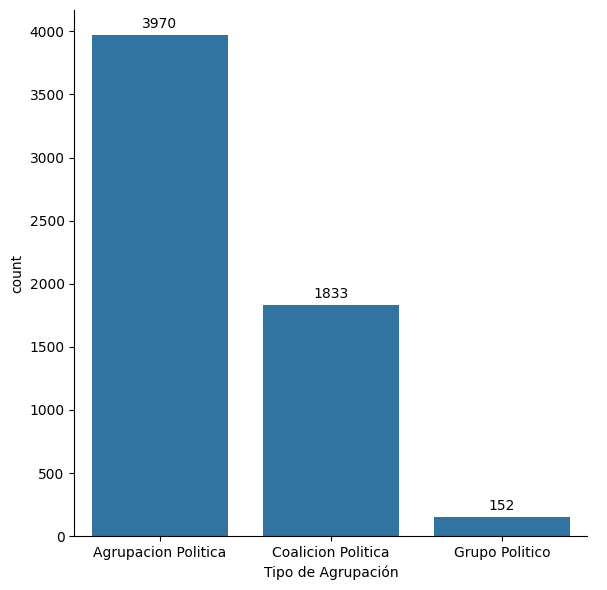

In [35]:
sns.catplot(
    x="Tipo de Agrupación",
    # col="Cargo",
    kind="count",
    height=6,
    aspect=1,
    data=df,
)
autoLabel()
plt.show()

c:\Users\SergioxD\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


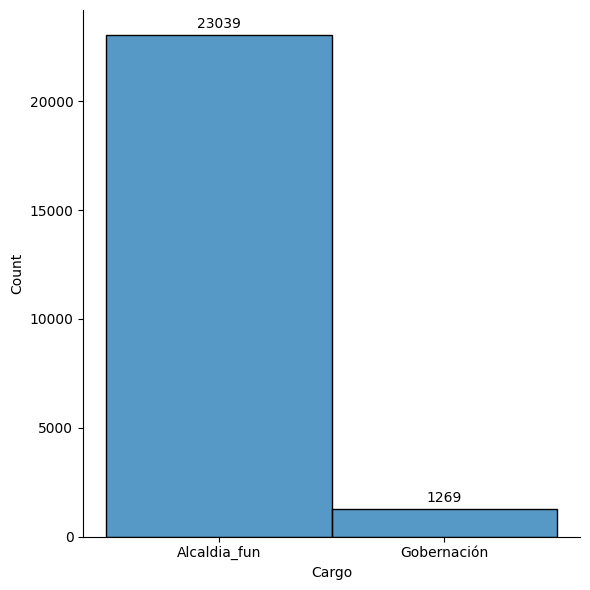

In [36]:
sns.displot(data=gastos_df, x="Cargo", height=6, aspect=1)
autoLabel()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_27432\2759330335.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sum_gastos.values, y=sum_gastos.index, palette="viridis")


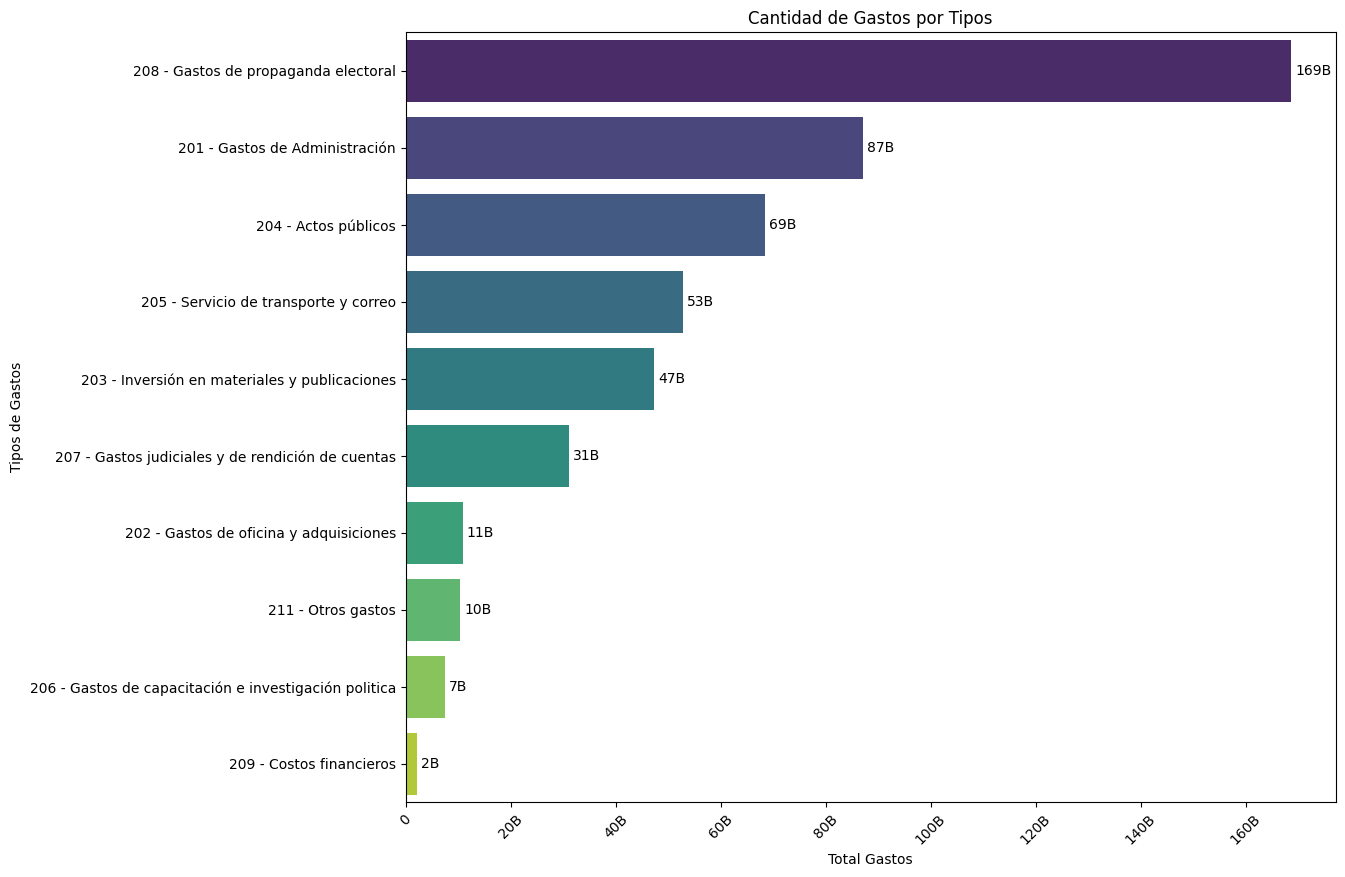

In [37]:
# Sumar los valores de cada tipo de gasto
sum_gastos = df[gasto_columns].sum()
sum_gastos = sum_gastos.sort_values(ascending=False)  # Ordenar de mayor a menor


# Crear la gráfica
plt.figure(figsize=(12, 10))
sns.barplot(x=sum_gastos.values, y=sum_gastos.index, palette="viridis")
plt.title("Cantidad de Gastos por Tipos")
plt.xlabel("Total Gastos")
plt.ylabel("Tipos de Gastos")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(func_form_millon_billon)
# plt.gca().yaxis.set_ticklabels(func_form_millon_billon)
autoLabelY()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_27432\2956297197.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sum_ingresos.values, y=sum_ingresos.index, palette="viridis")


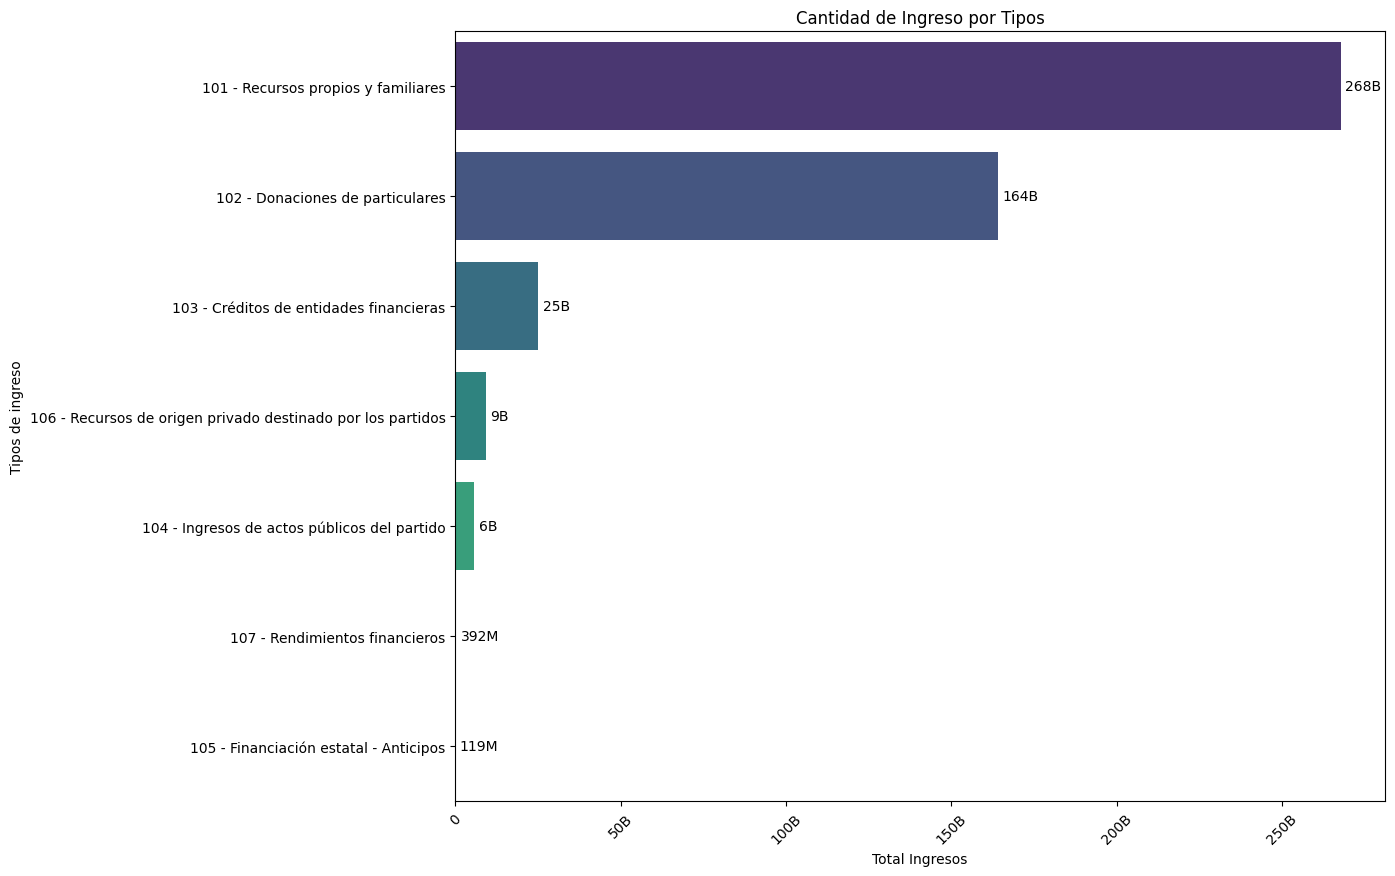

In [38]:
# Sumar los valores de cada tipo de gasto
sum_ingresos = df[ingresos_columns].sum()
sum_ingresos = sum_ingresos.sort_values(ascending=False)  # Ordenar de mayor a menor


# Crear la gráfica
plt.figure(figsize=(12, 10))
sns.barplot(x=sum_ingresos.values, y=sum_ingresos.index, palette="viridis")
plt.title("Cantidad de Ingreso por Tipos")
plt.xlabel("Total Ingresos")
plt.ylabel("Tipos de ingreso")
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(func_form_millon_billon)
# plt.gca().yaxis.set_ticklabels(func_form_millon_billon)
autoLabelY()
plt.show()

C:\Users\SergioxD\AppData\Local\Temp\ipykernel_27432\3037853071.py:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().xaxis.set_ticklabels(format_long_text)


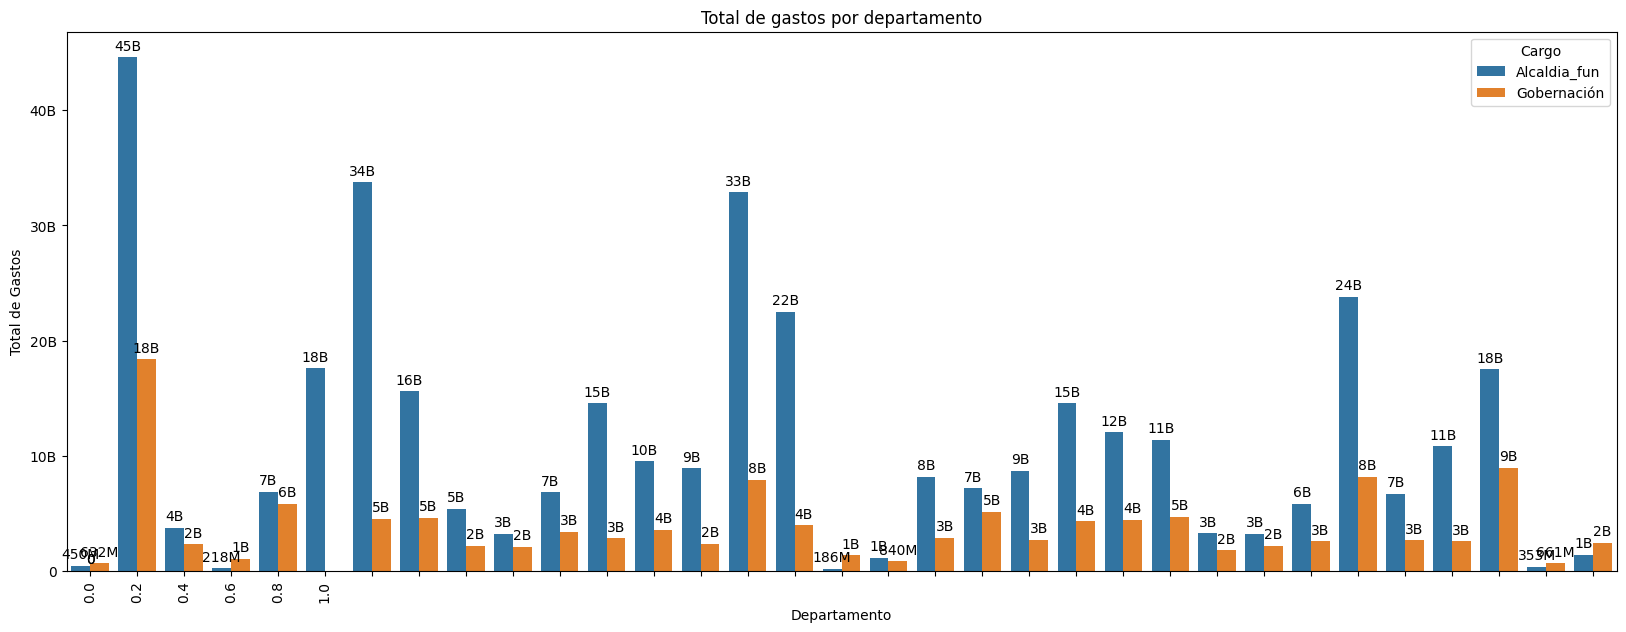

In [39]:
plt.figure(figsize=(20, 7))
sns.barplot(
    x="Departamento",
    y="Total de Gastos",
    hue="Cargo",
    # dodge=False,
    data=df.groupby(["Departamento", "Cargo"])["Total de Gastos"].sum().reset_index(),
    # aspect=2
)


plt.title("Total de gastos por departamento")
plt.xticks(rotation=90)

plt.gca().xaxis.set_ticklabels(format_long_text)
plt.gca().yaxis.set_major_formatter(func_form_millon_billon)
autoLabel()

plt.show()

In [40]:
df.head()

,Nombre,Cargo,Sexo,Departamento,Ciudades,Tipo de Agrupación,Nombre de Agrupación,Contar_x,201 - Gastos de Administración,202 - Gastos de oficina y adquisiciones,...,103 - Créditos de entidades financieras,105 - Financiación estatal - Anticipos,Total de Ingresos,proportion 101 - Recursos propios y familiares,proportion 102 - Donaciones de particulares,proportion 106 - Recursos de origen privado destinado por los partidos,proportion 107 - Rendimientos financieros,proportion 104 - Ingresos de actos públicos del partido,proportion 103 - Créditos de entidades financieras,proportion 105 - Financiación estatal - Anticipos
0,abad_de_jesus_marin_arcila,Alcaldia_fun,M,Antioquia,San Rafael,Agrupacion Politica,PARTIDO COLOMBIA RENACIENTE,4.0,0.0,0.0,...,0.0,0.0,41100000.0,0.705596,0.002433,0.291971,0.0,0.0,0.0,0.0
1,abel_alberto_polanco_lemos,Alcaldia_fun,M,Bolívar,Tiquisio,Agrupacion Politica,PARTIDO NUEVO LIBERALISMO,19.0,0.0,0.0,...,0.0,0.0,25000000.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,abel_angel_quiñones_urbano,Alcaldia_fun,M,Nariño,Ricaurte,Agrupacion Politica,"MOVIMIENTO AUTORIDADES INDIGENAS DE COLOMBIA ""...",6.0,6300000.0,0.0,...,0.0,0.0,9500000.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,abel_antonio_cepeda_macias,Alcaldia_fun,M,Atlántico,Sabanalarga,Agrupacion Politica,PARTIDO DEMOCRATA COLOMBIANO,15.0,0.0,0.0,...,0.0,0.0,10500000.0,1.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
4,abel_antonio_paternina_orozco,Alcaldia_fun,M,Bolívar,Arroyohondo,Coalicion Politica,NUEVO LIBERALISMO - CAMBIO RADICAL,1.0,0.0,0.0,...,0.0,0.0,8855000.0,0.607002,0.392998,0.000000,0.0,0.0,0.0,0.0


In [41]:
df.to_csv('data/output/ingresos_gastos.csv', index=False)

## Se agrega el df de reglas

In [42]:
path_censo_electoral_topes = (
    "data/input/rule/230811-CENSO-ELECTORAL-CON-TOPES-2023.xlsx"
)
rule_df = pd.read_excel(
    path_censo_electoral_topes, engine="openpyxl", sheet_name="ALCALDIA"
)

rule_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1121 entries, 0 to 1120
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   DEPARTAMENTO        1121 non-null   object
 1   MUNICIPIO           1121 non-null   object
 2   TOTAL               1121 non-null   int64 
 3   TOPE GASTOS         1121 non-null   int64 
 4   MAX_CURUL           1121 non-null   int64 
 5   GERENTE DE CAMPAÑA  1121 non-null   object
dtypes: int64(3), object(3)
memory usage: 52.7+ KB


In [43]:
# Función para normalizar los nombres
def normalizeDepartment(departamento):
    # Convertir a minúsculas
    departamento = departamento.lower()
    # Eliminar tildes y caracteres especiales
    departamento = unidecode.unidecode(departamento)
    # Reemplazos específicos
    replacements = {
        'valle del cauca': 'valle',  # Unificar Valle del Cauca con Valle
        'bogota d.c.': 'bogota. d.c.',  # Unificar variación en punto
        'archipielago de san andres, providencia y santa catalina': 'san andres',  # Simplificar San Andrés
    }
    return replacements.get(departamento, departamento)

# Función para normalizar los nombres
def normalizeCity(city):
    # Convertir a minúsculas
    city = city.lower()
    # Eliminar tildes y caracteres especiales
    city = unidecode.unidecode(city)
    # Reemplazos específicos
    replacements = {
        'valle del cauca': 'valle',  # Unificar Valle del Cauca con Valle
        'bogota d.c.': 'bogota. d.c.',  # Unificar variación en punto
        'archipielago de san andres, providencia y santa catalina': 'san andres',  # Simplificar San Andrés
    }
    return replacements.get(city, city)

df['departamento_normalizado'] = df['Departamento'].apply(normalizeDepartment)
rule_df['departamento_normalizado'] = rule_df['DEPARTAMENTO'].apply(normalizeDepartment)


df['ciudad_normalizado'] = df['Ciudades'].apply(normalizeCity)
rule_df['ciudad_normalizado'] = rule_df['MUNICIPIO'].apply(normalizeCity)

In [44]:
rule_df['TOPE DONACIONES'] = rule_df['TOPE GASTOS'] * 0.1

In [45]:
rule_df.head()

,DEPARTAMENTO,MUNICIPIO,TOTAL,TOPE GASTOS,MAX_CURUL,GERENTE DE CAMPAÑA,departamento_normalizado,ciudad_normalizado,TOPE DONACIONES
0,AMAZONAS,EL ENCANTO,783,144319596,1,NO,amazonas,el encanto,14431959.6
1,AMAZONAS,LA CHORRERA,1061,144319596,1,NO,amazonas,la chorrera,14431959.6
2,AMAZONAS,LA PEDRERA,1179,144319596,1,NO,amazonas,la pedrera,14431959.6
3,AMAZONAS,LA VICTORIA,65,144319596,1,NO,amazonas,la victoria,14431959.6
4,AMAZONAS,LETICIA,42092,274894466,1,SI,amazonas,leticia,27489446.6


C:\Users\SergioxD\AppData\Local\Temp\ipykernel_27432\2580145382.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_filtrado, x='MUNICIPIO', y='TOPE GASTOS', palette='viridis')


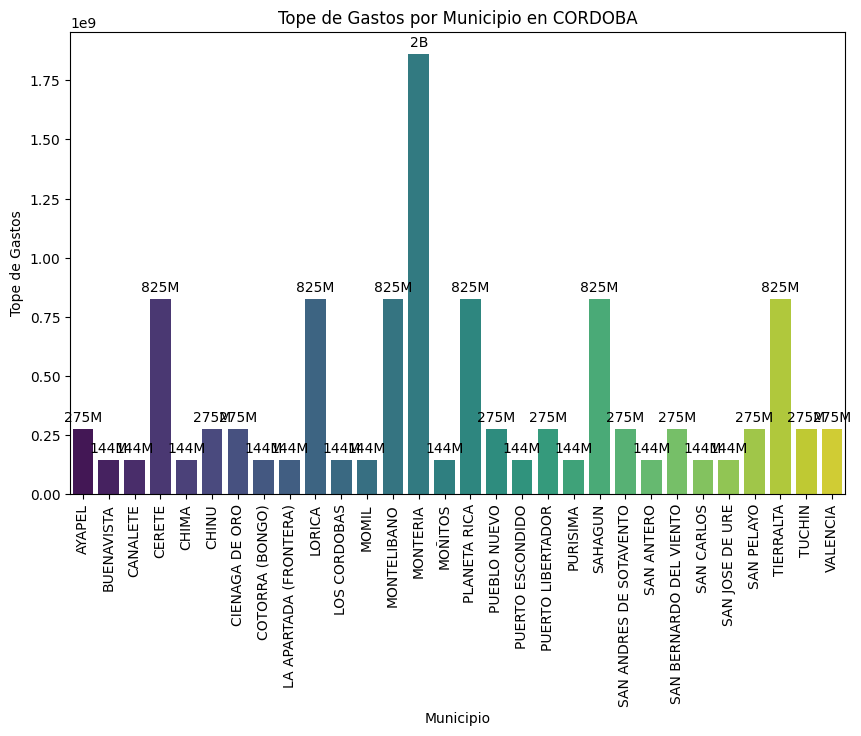

In [46]:

# Filtrar el DataFrame por el departamento específico (en este caso AMAZONAS)
departamento_especifico = 'CORDOBA'
df_filtrado = rule_df[rule_df['DEPARTAMENTO'] == departamento_especifico]

# Crear una gráfica de barras que muestre el tope de gastos por municipio
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtrado, x='MUNICIPIO', y='TOPE GASTOS', palette='viridis')

# Personalizar la gráfica
plt.title(f'Tope de Gastos por Municipio en {departamento_especifico}')
plt.xlabel('Municipio')
plt.ylabel('Tope de Gastos')
plt.xticks(rotation=90)
autoLabel()

# Mostrar la gráfica
plt.show()

## Mostrar diferencias para el campo de departamento y ciudades

In [47]:
# Verificar nuevamente después de corrección
departamentos_rules_corrected = set(rule_df['departamento_normalizado'].dropna())
departamentos_data_corrected = set(df['departamento_normalizado'].dropna())

ciudades_rules_corrected = set(rule_df['ciudad_normalizado'].dropna())
ciudades_data_corrected = set(df['ciudad_normalizado'].dropna())

# Imprimir resultados para verificar
print(f"Departamentos corregidos en df_data pero no en df_rules: {departamentos_data_corrected - departamentos_rules_corrected}")
print(f"Departamentos corregidos en df_rules pero no en df_data: {departamentos_rules_corrected - departamentos_data_corrected}")

print(f"Ciudades corregidas en df_data pero no en df_rules: {ciudades_data_corrected - ciudades_rules_corrected}")
print(f"Ciudades corregidas en df_rules pero no en df_data: {ciudades_rules_corrected - ciudades_data_corrected}")


Departamentos corregidos en df_data pero no en df_rules: set()
Departamentos corregidos en df_rules pero no en df_data: set()
Ciudades corregidas en df_data pero no en df_rules: {'los andes', 'rio quito', 'bajo baudo', 'pueblo viejo', 'san andres de tumaco', 'arboleda', 'yondo', 'la argentina', 'ciudad bolivar', 'san juan de betulia', 'mallama', 'arroyohondo', 'magui', 'cotorra', 'guadalajara de buga', 'leguizamo', 'san luis de since', 'aquitania', 'rio frio', 'santafe de antioquia', 'patia', 'paz de ariporo', 'desconocido', 'tiquisio', 'bojaya', 'francisco pizarro', 'rio viejo', 'alto baudo', 'santacruz', 'medio baudo', 'buena vista', 'paratebueno', 'bahia solano', 'cerro san antonio', 'tesalia', 'armero', 'purace', 'zona bananera', 'san juan de rio seco', 'galeras', 'sotara', 'coloso', 'villa de leyva', 'valle del guamuez', 'ariguani', 'lopez', 'atrato', 'san andres sotavento', 'san andres de cuerquia', 'villa de san diego de ubate', 'roberto payan', 'tolu viejo', 'barranco minas', '

In [48]:
# Función para corregir ciudad según coincidencia por departamento
def corregir_ciudad_por_departamento(row):
    depto = row['departamento_normalizado']
    ciudad = row['ciudad_normalizado']
    
    # Filtrar las ciudades de df_rules que pertenezcan al mismo departamento
    ciudades_en_depto = rule_df[rule_df['departamento_normalizado'] == depto]['ciudad_normalizado'].unique()
    
    # Buscar coincidencia aproximada dentro del mismo departamento
    if len(ciudades_en_depto) > 0:
        coincidencia, score = process.extractOne(ciudad, ciudades_en_depto)
        if score > 80:  # Umbral de similitud
            return coincidencia
    return ciudad  # Devolver la ciudad original si no hay buena coincidencia

# Aplicar la corrección automática basada en departamento
df['ciudad_normalizado'] = df.apply(corregir_ciudad_por_departamento, axis=1)

In [49]:
# Crear un diccionario para almacenar las diferencias
diferencias_por_departamento = {}

# Obtener los departamentos únicos de df_rules y df_data
departamentos_rules = rule_df['departamento_normalizado'].unique()
departamentos_data = df['departamento_normalizado'].unique()

# Iterar sobre los departamentos presentes en ambos DataFrames
for dept in set(departamentos_rules).intersection(departamentos_data):
    # Filtrar las ciudades por departamento en ambos DataFrames
    ciudades_rules = set(rule_df[rule_df['departamento_normalizado'] == dept]['ciudad_normalizado'])
    ciudades_data = set(df[df['departamento_normalizado'] == dept]['ciudad_normalizado'])
    
    # Encontrar diferencias en las ciudades para el departamento actual
    diferencias_data = ciudades_data - ciudades_rules
    diferencias_rules = ciudades_rules - ciudades_data
    
    # Guardar las diferencias en el diccionario
    diferencias_por_departamento[dept] = {
        'En df_data pero no en df_rules': diferencias_data,
        'En df_rules pero no en df_data': diferencias_rules
    }

# Mostrar diferencias por departamento
for dept, difs in diferencias_por_departamento.items():
    print(f"Departamento: {dept}")
    print(f"  Ciudades en df_data pero no en df_rules: {difs['En df_data pero no en df_rules']}")
    print(f"  Ciudades en df_rules pero no en df_data: {difs['En df_rules pero no en df_data']}")

Departamento: norte de santander
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: guaviare
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: risaralda
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: quindio
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: la guajira
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: cauca
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: narino
  Ciudades en df_data pero no en df_rules: {'desconocido'}
  Ciudades en df_rules pero no en df_data: set()
Departamento: santander
  Ciudades en df_data pero no en df_rules: {'descono

In [50]:
rule_df.to_csv('data/output/rule_df.csv', index=False)

In [51]:
# Unir df con df_rules basados en Departamento y Ciudades
df_enriquecido = pd.merge(df, rule_df, on=['departamento_normalizado', 'ciudad_normalizado'], how='left')

In [52]:
# Cálculo de los índices de cumplimiento
df_enriquecido['Indice_Gastos'] = df_enriquecido['Total de Gastos'] / df_enriquecido['TOPE GASTOS']
df_enriquecido['Indice_Donaciones'] = df_enriquecido['102 - Donaciones de particulares'] / df_enriquecido['TOPE DONACIONES']

# Manejar posibles divisiones por cero (en caso de que el tope sea 0)
df_enriquecido['Indice_Gastos'].replace([float('inf'), -float('inf')], 0, inplace=True)
df_enriquecido['Indice_Donaciones'].replace([float('inf'), -float('inf')], 0, inplace=True)

# Opcional: Promedio o suma de los índices para un índice general de cumplimiento
df_enriquecido['Indice_Cumplimiento_Total'] = (df_enriquecido['Indice_Gastos'] + df_enriquecido['Indice_Donaciones']) / 2


In [53]:
df_enriquecido[['Nombre', 'Ciudades', 'Total de Gastos', 'TOPE GASTOS', 'Indice_Gastos', '102 - Donaciones de particulares', 'TOPE DONACIONES', 'Indice_Donaciones', 'Indice_Cumplimiento_Total']].head()

,Nombre,Ciudades,Total de Gastos,TOPE GASTOS,Indice_Gastos,102 - Donaciones de particulares,TOPE DONACIONES,Indice_Donaciones,Indice_Cumplimiento_Total
0,abad_de_jesus_marin_arcila,San Rafael,18200000.0,144319596.0,0.126109,100000.0,14431959.6,0.006929,0.066519
1,abel_alberto_polanco_lemos,Tiquisio,27000000.0,144319596.0,0.187085,0.0,14431959.6,0.000000,0.093542
2,abel_angel_quiñones_urbano,Ricaurte,9500000.0,144319596.0,0.065826,0.0,14431959.6,0.000000,0.032913
3,abel_antonio_cepeda_macias,Sabanalarga,12100000.0,824683400.0,0.014672,0.0,82468340.0,0.000000,0.007336
4,abel_antonio_paternina_orozco,Arroyohondo,8855000.0,144319596.0,0.061357,3480000.0,14431959.6,0.241131,0.151244


In [54]:
df_enriquecido[['Total de Gastos', '102 - Donaciones de particulares']].describe()

,Total de Gastos,102 - Donaciones de particulares
count,5.916000e+03,5.921000e+03
mean,8.217545e+07,2.770319e+07
std,3.991159e+08,1.479422e+08
min,0.000000e+00,0.000000e+00
25%,5.760750e+06,0.000000e+00
50%,2.314964e+07,5.000000e+04
75%,6.276755e+07,9.000000e+06
max,2.136200e+10,5.014104e+09


In [55]:
corr_matrix = df_enriquecido[['Total de Gastos', '102 - Donaciones de particulares', 'Indice_Gastos', 'Indice_Donaciones']].corr()
print(corr_matrix)

                                  Total de Gastos  \
Total de Gastos                          1.000000   
102 - Donaciones de particulares         0.529830   
Indice_Gastos                            0.853054   
Indice_Donaciones                        0.161147   

                                  102 - Donaciones de particulares  \
Total de Gastos                                           0.529830   
102 - Donaciones de particulares                          1.000000   
Indice_Gastos                                             0.022457   
Indice_Donaciones                                         0.451382   

                                  Indice_Gastos  Indice_Donaciones  
Total de Gastos                        0.853054           0.161147  
102 - Donaciones de particulares       0.022457           0.451382  
Indice_Gastos                          1.000000           0.063089  
Indice_Donaciones                      0.063089           1.000000  


In [56]:
df_enriquecido.to_csv('data/output/df_enriquecido.csv', index=False)